# Reinforcement Learning

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os
import gym

## Introduction to OpenAI gym

In this notebook we will be using OpenAI gym, a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning agents to interact with.

Let's list all the available environments:

In [2]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [3]:
env = gym.make('CartPole-v1')

Let's initialize the environment by calling is reset() method. This returns an observation:

In [4]:
obs = env.reset()

In [5]:
obs

array([-0.02651217, -0.03500301,  0.0030672 ,  0.00831521])

In [6]:
env.render()

True

In [7]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [8]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

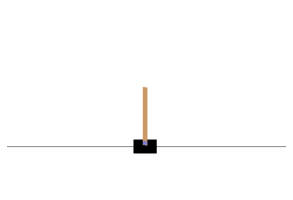

In [9]:
plot_environment(env)
plt.show()

Let’s ask the environment what actions are possible:

In [10]:
env.action_space

Discrete(2)

In [11]:
action = 0  # accelerate left

In [12]:
obs, reward, done, info = env.step(action)

In [13]:
obs

array([-0.02721223, -0.23016881,  0.0032335 ,  0.30196429])

In [14]:
reward

1.0

In [15]:
done

False

In [16]:
info

{}

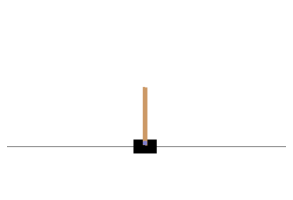

In [17]:
plot_environment(env)
plt.show()

## A simple hard-coded policy

In [18]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [19]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.244, 9.00891025596326, 24.0, 68.0)

In [20]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [21]:
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')

In [22]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [23]:
plot_animation(frames)

## Neural Network Policies



Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability p of the action 0 (left), and of course the probability of action 1 (right) will be 1 - p.


In [25]:
n_inputs = 4 

model = keras.models.Sequential([
    keras.layers.Dense(5, activation = 'elu', input_shape = [n_inputs]),
    keras.layers.Dense(1, activation = 'sigmoid')
])



In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between exploring new actions and exploiting the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.


In [26]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [27]:
frames = render_policy_net(model)
plot_animation(frames)

In [29]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [30]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads